# How to (not) predict Bitcoin price (Episode I)

Hi! In this new entry I wanted to show you a quick project I was trying to carry to learn about *Recurrent Neural Networks*, specifically about *Long-short Term Memories*.

First of all, this must not be taken as financial advise, this is just an exercise to learn how to predict Multivariate Time Series with Deep Learning techniques. I have 0 knowledge on stoke markets and how they work, and I just wanted to see if a blackbox algorithm like a neural network can make a newbie like me rich in a couple of days (it took me that time to deploy this simple model). *Spoiler: it didn't make me rich*


Bitcoin is known to be a very complicated time series, with many external factors (even manipulation from some sectors and fake volumes by exchanges) and a huge variance (it can multiply its price by 2 in 24h). I have to say I expect nothing spectacular from this excercise, since it's just a homemade solution in just one day with an old laptop which means I can't test many models.

Let's find out how I trained the net.

## Data Preprocessing

First of all, we need to do a bit of preprocessing, since Change% is treated like a string and Volume is expressed in "Thousands" with a k at the end (4k = 4000, 4M=4000k). Therefore, we need to strip that last letter and convert both observations consequently

In [1]:
import pandas as pd

import numpy as np

data=pd.read_csv("bitcoinhist.csv",thousands=",")

data=data.iloc[::-1]
data=data.iloc[:,1:]
data=data.reset_index(drop=True)
data["Change %"]=[float(i.strip("%"))/100 for i in data["Change %"]]

volaux=np.zeros(len(data["Vol."]))
for k in range(len(data["Vol."])):
    try:
        obs=data.iloc[k,4]
        multiplier=1
        if obs[-1]=="M":
            multiplier=1000

        volaux[k]=float(obs[:-1])*multiplier
            
    except:
        volaux[k]=(volaux[k-1]+volaux[k-2])/2

data["Vol."]=volaux
data

,Price,Open,High,Low,Vol.,Change %
0,0.3,0.3,0.3,0.3,4.94,0.0000
1,0.3,0.3,0.3,0.3,15.44,0.0000
2,0.3,0.3,0.3,0.3,18.61,0.0000
3,0.3,0.3,0.3,0.3,2.54,0.0000
4,0.3,0.3,0.3,0.3,1.45,0.0000
...,...,...,...,...,...,...
3314,8405.1,8678.5,8687.3,8309.6,722.67,-0.0315
3315,8439.9,8404.9,8522.0,8242.6,617.02,0.0041
3316,8341.6,8439.9,8447.6,8277.2,444.00,-0.0117
3317,8607.8,8341.6,8607.8,8304.9,468.34,0.0319


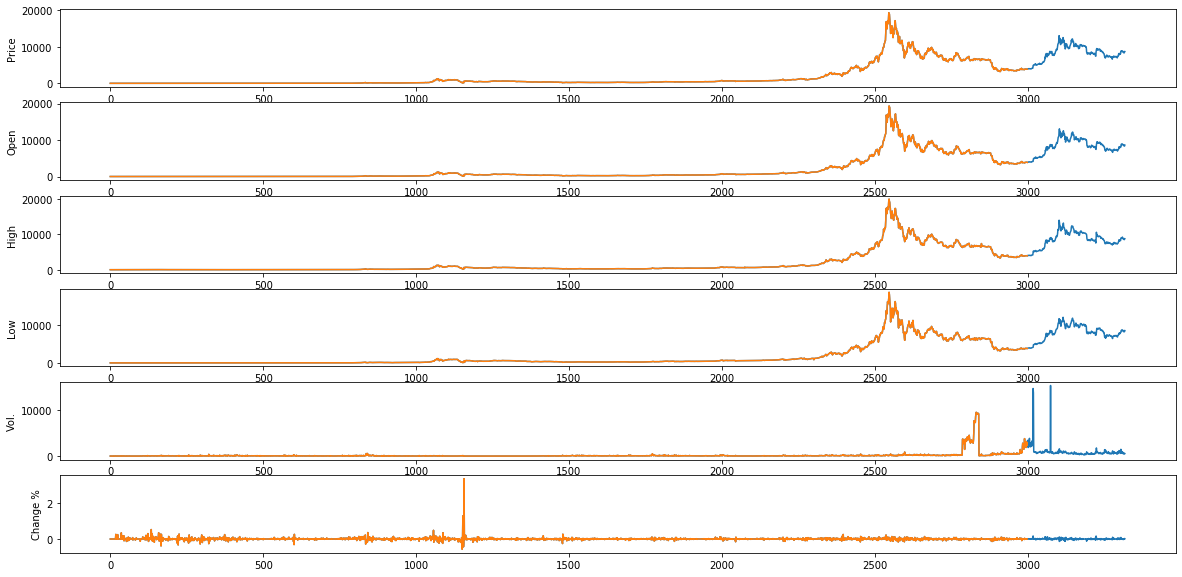

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X=np.asarray(data)
X_train=X[0:3000,:]
X_test=X[3000:,:]



fig, axes = plt.subplots(6,figsize=(20,10))

for s in range(len(axes)):
    axes[s].plot(X[:,s])
    axes[s].set_ylabel(data.columns[s])
    axes[s].plot(X_train[:,s])

I splitted my data in train and test, so I have some data that the net has never seen and would give me an accurate intuition of how it's performing

## TimeSeriesGenerator


Keras provides an utility for sequence segmentation. With TimeseriesGenerator we can just pass the series and tell it the length of the window (previous values) to predict the next ones.

The reason to ask for a 128 batch size is because powers of two are more computationally efficient, since computers memories are structured in bits/bytes

In [3]:
from keras.preprocessing.sequence import TimeseriesGenerator

window=7
series_train = TimeseriesGenerator(X_train, X_train, length=window, batch_size=128)

Using TensorFlow backend.


# Model 

I decided to go with this architecture after some trials, but in deep learning there is no solid guide to choose the architecture but trial and error.

Basically i stacked two layers of LSTM cells with Dropout (regularization technique that blocks some neurons while training randomly to avoid overfitting. This prevents that some neurons become so important that the rest won't get to train). I used MAE as my loss function, since it's a very popular metric in stock analysis

In [4]:
from keras.layers import LSTM,Dense,TimeDistributed,Dropout
from keras import Sequential
from keras.utils import plot_model


model = Sequential()
model.add(LSTM(200, activation='relu',return_sequences=True, input_shape=(window, X.shape[1])))
model.add(LSTM(100, activation='relu', return_sequences=False))
model.add(Dense(100, activation='relu'))
model.add(Dense(6))
model.compile(optimizer='adam', loss='mean_absolute_error')

It's important to use fit_generator instead of fit when using generators.

In [5]:
model.fit_generator(series_train, steps_per_epoch=len(series_train),epochs=200)

Epoch 1/200
24/24 [==============================] - 3s 132ms/step - loss: 957.4973
Epoch 2/200
24/24 [==============================] - 2s 73ms/step - loss: 244.7037
Epoch 3/200
24/24 [==============================] - 2s 74ms/step - loss: 219.0776
Epoch 4/200
24/24 [==============================] - 2s 79ms/step - loss: 211.0365
Epoch 5/200
24/24 [==============================] - 2s 73ms/step - loss: 265.4349
Epoch 6/200
24/24 [==============================] - 2s 89ms/step - loss: 156.4848
Epoch 7/200
24/24 [==============================] - 2s 86ms/step - loss: 214.0896
Epoch 8/200
24/24 [==============================] - 2s 63ms/step - loss: 192.2619: 0s -
Epoch 9/200
24/24 [==============================] - 1s 62ms/step - loss: 176.6612
Epoch 10/200
24/24 [==============================] - 2s 71ms/step - loss: 174.3929
Epoch 11/200
24/24 [==============================] - 2s 65ms/step - loss: 133.7304
Epoch 12/200
24/24 [==============================] - 2s 66ms/step - loss: 186

24/24 [==============================] - 2s 86ms/step - loss: 205.2920: 0s - loss: 199
Epoch 99/200
24/24 [==============================] - 2s 86ms/step - loss: 125.2240
Epoch 100/200
24/24 [==============================] - 2s 71ms/step - loss: 125.0039
Epoch 101/200
24/24 [==============================] - 2s 89ms/step - loss: 139.5396
Epoch 102/200
24/24 [==============================] - 2s 94ms/step - loss: 108.1612
Epoch 103/200
24/24 [==============================] - 2s 99ms/step - loss: 109.7738
Epoch 104/200
24/24 [==============================] - 2s 76ms/step - loss: 100.9526
Epoch 105/200
24/24 [==============================] - 2s 69ms/step - loss: 94.4511
Epoch 106/200
24/24 [==============================] - 2s 74ms/step - loss: 92.7693
Epoch 107/200
24/24 [==============================] - 2s 74ms/step - loss: 111.6563
Epoch 108/200
24/24 [==============================] - 2s 88ms/step - loss: 138.7038
Epoch 109/200
24/24 [==============================] - 2s 80ms/ste

24/24 [==============================] - 1s 50ms/step - loss: 107.4888
Epoch 196/200
24/24 [==============================] - 1s 48ms/step - loss: 162.8679
Epoch 197/200
24/24 [==============================] - 1s 39ms/step - loss: 132.1113
Epoch 198/200
24/24 [==============================] - 1s 47ms/step - loss: 96.5370
Epoch 199/200
24/24 [==============================] - 1s 45ms/step - loss: 67.9066
Epoch 200/200
24/24 [==============================] - 1s 51ms/step - loss: 77.6605


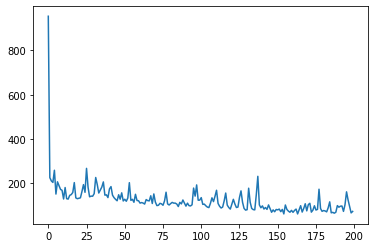

In [6]:
plt.plot(model.history.history["loss"])

The loss function seems to have decreased althought it's kinda bad, it's not a steady descent. Let's see how it fits the time series in the train data

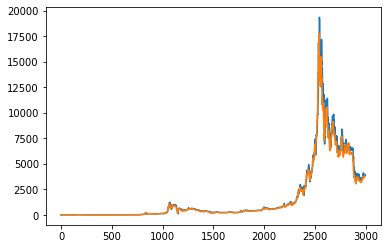

In [7]:
predicted_train=model.predict_generator(series_train)

price_pred_train=predicted_train[:,0]
price=X_train[:,0]
plt.plot(price)
plt.plot(price_pred_train)

Pretty good huh? However, such a good fitting could imply overfitting (we may have trained for too much epochs). Let's use our test data to check if the fitting is that good in unseen data!

## Time to go test

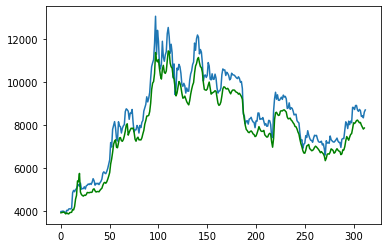

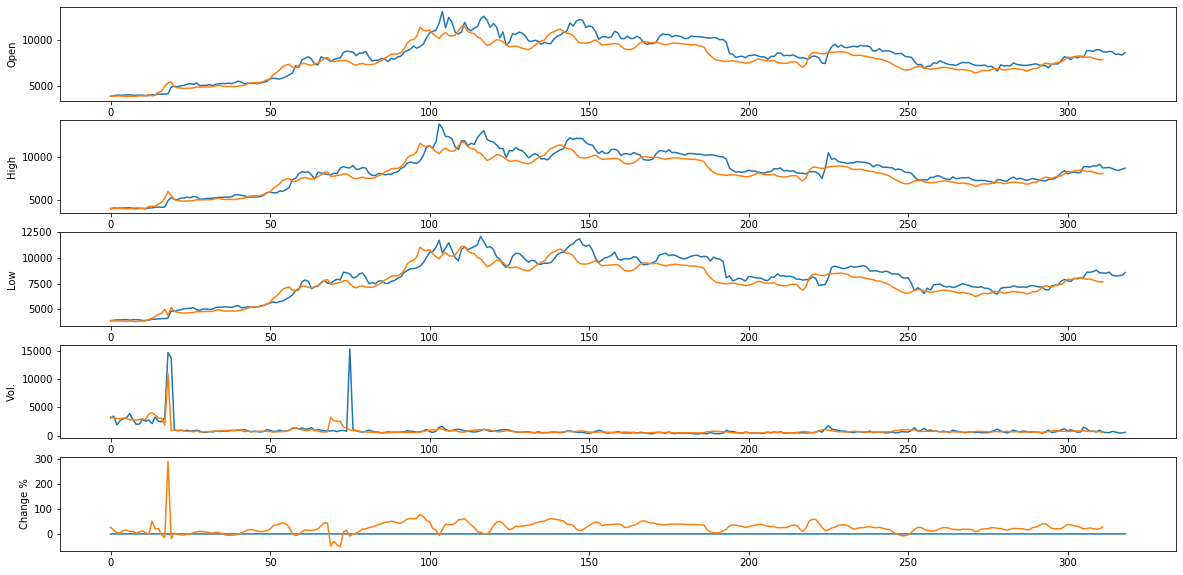

In [8]:
series_test = TimeseriesGenerator(X_test, X_test, length=window, batch_size=128)

predicted_test=model.predict_generator(series_test)
price_pred_test=predicted_test[:,0]
price_test=X_test[:,0]

plt.plot(price_test[6:])
plt.plot(price_pred_test,color="g")

fig, axes = plt.subplots(5,figsize=(20,10))

for s in range(0,len(axes)):
    axes[s].plot(X_test[:,s+1])
    axes[s].set_ylabel(data.columns[s+1])
    axes[s].plot(predicted_test[:,s+1])

Not a bad fit, specially for the price! We gonna be rich! Wait, there is something wrong with this. So easy, I created a really good predictor in my bedroom, why doesn't everyone do this?

This results are a bit tricky. There is not much point in predicting to one day. Some Markovian models work like this (thanks to Alf from DataScienceSpain for the hints around this topic), as the best prediction for tomorrows value is todays value, which gathers a lot of information on the past days. Will I earn some money? Let's make a simulation, starting with 1000$

Text(0, 0.5, 'BTC count')

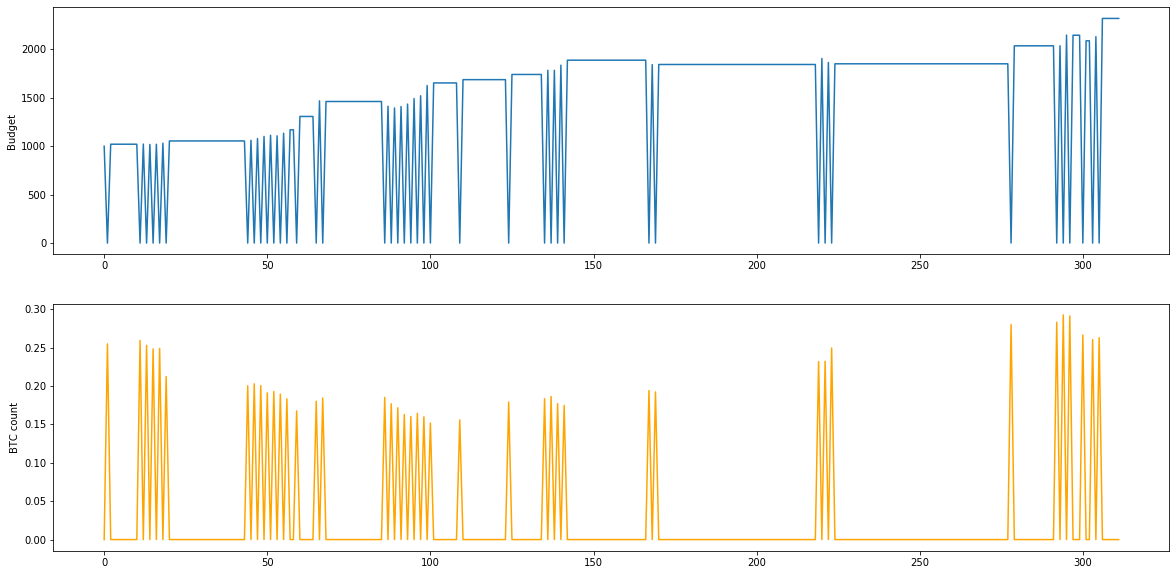

In [9]:
budget=1000
btcs=0
predicted_price=price_pred_test


budget_hist=[budget]
btcs_hist=[btcs]
for tomorrow in range(1,X_test.shape[0]-window):
    today=tomorrow-1
    
    if predicted_price[tomorrow]>price_test[today] and budget>0: #If i predict the price is going up from todays and i have money, we buy some btc
        btcs=budget/price_test[today]
        budget=0
    elif btcs>0: #we sell everything if it's gonna go down
        #print("vendo")
        budget=btcs*price_test[today]
        btcs=0
    budget_hist=budget_hist+[budget]
    btcs_hist=btcs_hist+[btcs]
    
fig, (ax1,ax2) = plt.subplots(2,figsize=(20,10))
ax1.plot(budget_hist)
ax1.set_ylabel("Budget")

ax2.plot(btcs_hist,color="orange")
ax2.set_ylabel("BTC count")

In [10]:
print("Ended up with ",btcs_hist[-1]," bitcoins")
print("Ended up with ",budget_hist[-1],"dollars")

Ended up with  0  bitcoins
Ended up with  2320.0953230841988 dollars


In 1000 days, my algorithm only made 379 dollars, which is not that amusing. My best mark was at past 100 days where I made 750$, that means that I had a 1.379 \% profit in 300 days. Not that great

## Let's make it harder, let's predict based on past predictions

What happens if I trust my predictor to try to predict the next days? We will iterate feeding the last prediction as the input for the test data (suppose we don't know the test data, that is yet to come in the future)

In [11]:
last_7pred=np.atleast_2d(predicted_test[-(window+1):,:])

future_predictions=[]
for day in range(X_test.shape[0]):
    pred7_gen=TimeseriesGenerator(last_7pred,last_7pred,length=window,batch_size=1)
    predicted_value=list(model.predict_generator(pred7_gen))
    last_7pred=np.concatenate((last_7pred[1:,:],predicted_value))
    future_predictions=future_predictions+predicted_value


# Full series

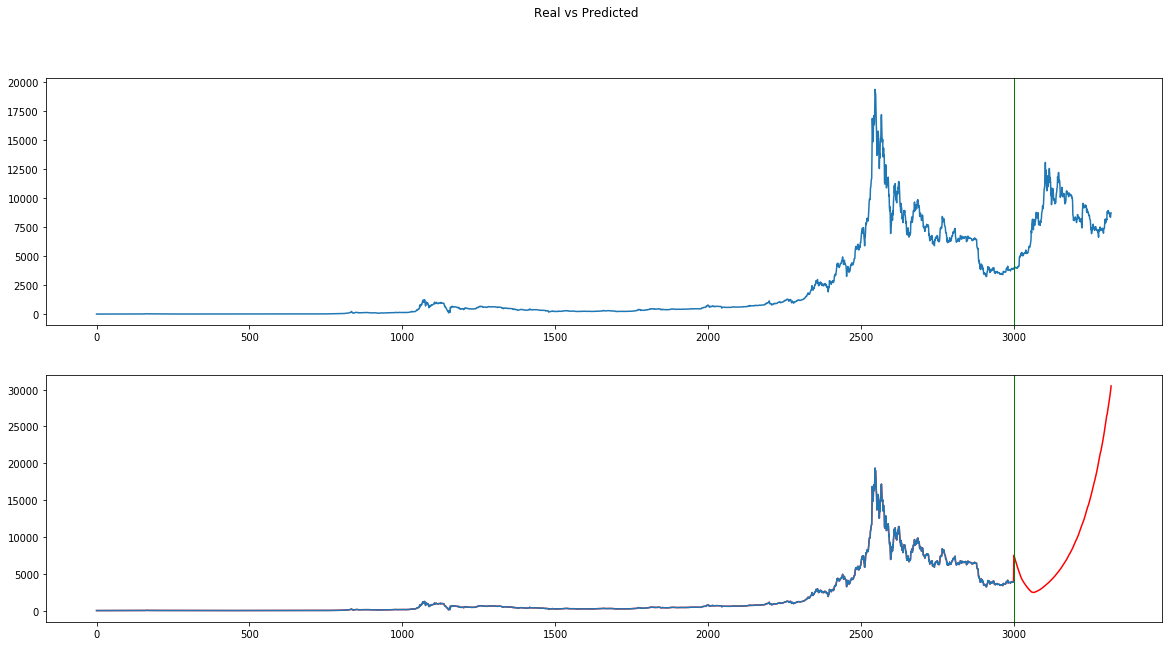

In [12]:
full_pred=np.concatenate((X_train,future_predictions))
full_price=X[:,0]


fig, (ax1, ax2) = plt.subplots(2,figsize=(20,10))
fig.suptitle('Real vs Predicted')

ax1.plot(X[:,0])

ax2.plot(full_pred[:,0],color="red")
ax2.plot(X_train[:,0])


ax1.axvline(x=3000, linewidth=1, color='g')
ax2.axvline(x=3000, linewidth=1, color='g')

That's the problem I was referring to earlier. My net has learnt that if the price arose in the past 7 days, it should go upwards. Therefore, if the first 7 predictions are upwards, this will feedback the net making the price prediction explode (according to my net, by 27th of January 1 BTC would cost 20 million dollars, pretty inaccurate I'd say)

# Final Thoughts

As I said, this was not a financial investment exercise, but more of a basic LSTM introduction. Although the fit on test is not bad, we can see that Bitcoin price is not such an easy time series to predict with unknown data.

We could try different architectures or use some finantial indicators as input variables. Maybe incorporate some new information or just use present data, since btc has evolved a lot since the old times.


Another good idea from statistical time series models such as ARIMAs (which I do know of from my university lessons but haven't tried for bitcoin) is to make the time series stationary (no trend and homogeneous variance).

Maybe I make a series out of this experience trying to improve my model and learn new things about forecasting time series.